# Customer segmentation


This notebook aims at analyzing the content of an E-commerce database that lists purchases made by $\sim$4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). Based on this analysis, I develop a model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase. <br>


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## 1. Data preparation

As a first step, I load all the modules that will be used in this notebook:

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

Then, I load the data. Once done, I also give some basic informations on the content of the dataframe: the type of the various variables, the number of null values and their percentage with respect to the total number of entries:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df_initial = pd.read_csv('/content/drive/MyDrive/ML project/ML_CS/data.csv',encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)

df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info = pd.concat([
    tab_info,
    pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}),
    pd.DataFrame((df_initial.isnull().sum() / df_initial.shape[0]) * 100).T.rename(index={0: 'null values (%)'})
])
display(tab_info)
display(df_initial[:5])

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [9]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info = pd.concat([
    tab_info,
    pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}),
    pd.DataFrame((df_initial.isnull().sum() / df_initial.shape[0]) * 100).T.rename(index={0: 'null values (%)'})
])
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


OK, therefore, by removing these entries we end up with a dataframe filled at 100% for all variables! Finally, I check for duplicate entries and delete them:

In [10]:
print('Duplicate Entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate Entries: 5225


___
## 2. Exploring the content
___
### 2.1 Countries

Here, I quickly look at the countries from which orders were made:

In [11]:
#It is primarily data preprocessing, as it deals with structuring and summarizing raw data. However, it also serves an EDA purpose to extract insights and validate the dataset's integrity.
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No. of distinct countries in the data frame  dataframe: {}'.format(len(countries)))

No. of distinct countries in the data frame  dataframe: 37


and show the result on a chloropleth map:



___
### 2.2 Customers and products


In [12]:
#This snippet computes the counts of unique products (StockCode), transactions (InvoiceNo), and customers (CustomerID) in the dataset.
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [13]:
# It computes the number of products in each basket (invoice) by counting InvoiceDate occurrences
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


In [14]:
#This ensures that any modifications made to df_cleaned do not affect the original df_initial DataFrame.
df_cleaned = df_initial.copy(deep = True)




___
#### 2.2.2 StockCode

Above, it has been seen that some values of the ** StockCode ** variable indicate a particular transaction (i.e. D for _Discount_). I check the contents of this variable by looking for the set of codes that would contain only letters:

In [15]:
#it involves identifying patterns in categorical variables and understanding their significance.
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [16]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges.


___
#### 2.2.3 Basket Price

I create a new variable that indicates the total price of every purchase:

In [17]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,-77183.6
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland,17.0
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland,13.2
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.0


Each entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made during a single order to recover the total order prize:

In [18]:
# Total Purchases per User & Order"
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# "Order Date"
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# "Selection of Significant Inputs"
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12346,541431,77183.60,2011-01-18 10:01:00.000000000
2,12347,537626,711.79,2010-12-07 14:57:00.000000000
3,12347,542237,475.39,2011-01-26 14:29:59.999999744
4,12347,549222,636.25,2011-04-07 10:43:00.000000000
5,12347,556201,382.52,2011-06-09 13:01:00.000000000
6,12347,562032,584.91,2011-08-02 08:48:00.000000000


In order to have a global view of the type of order performed in this dataset, I determine how the purchases are divided according to total prizes:

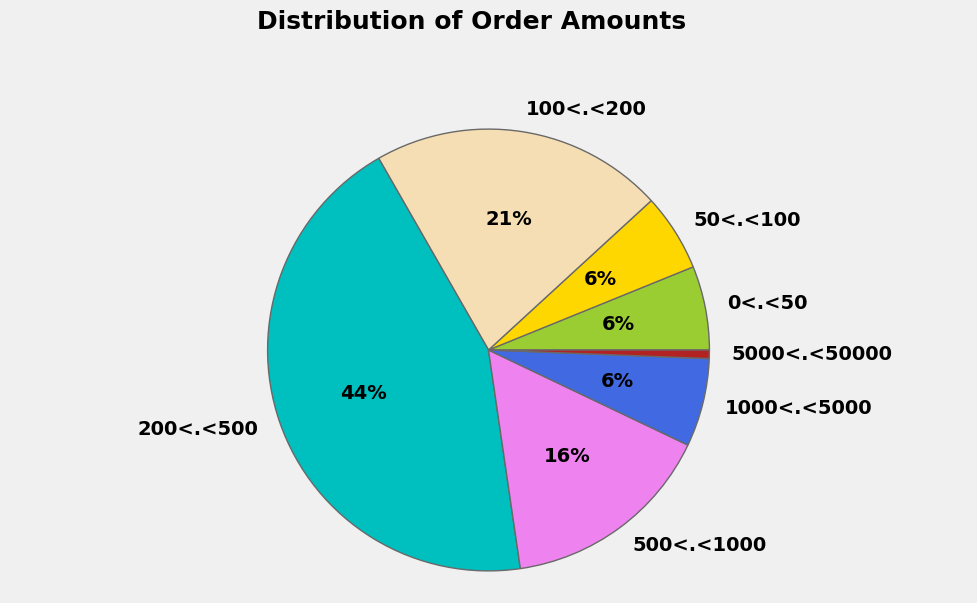

In [19]:
# Purchase Count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of Order Amounts", ha='center', fontsize = 18);



____
## 3. Insight on product categories

In the dataframe, products are uniquely identified through the **StockCode** variable. A short description of the products is given in the **Description** variable. In this section, I intend to use the content of this letter variable in order to group the products into different categories.

___
### 3.1 Products Description

As a first step, I extract from the **Description** variable the information that will prove useful. To do this, I use the following function:

In [20]:
#The keywords_inventory function extracts frequently occurring nouns from textual data, groups similar words under a common root, and identifies representative keywords
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1

    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [23]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [24]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Nb of keywords in variable 'Description': 1483


The execution of this function returns three variables:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

At this point, I convert the `count_keywords` dictionary into a list, to sort the keywords according to their occurences:

In [25]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I create a representation of the most common keywords:

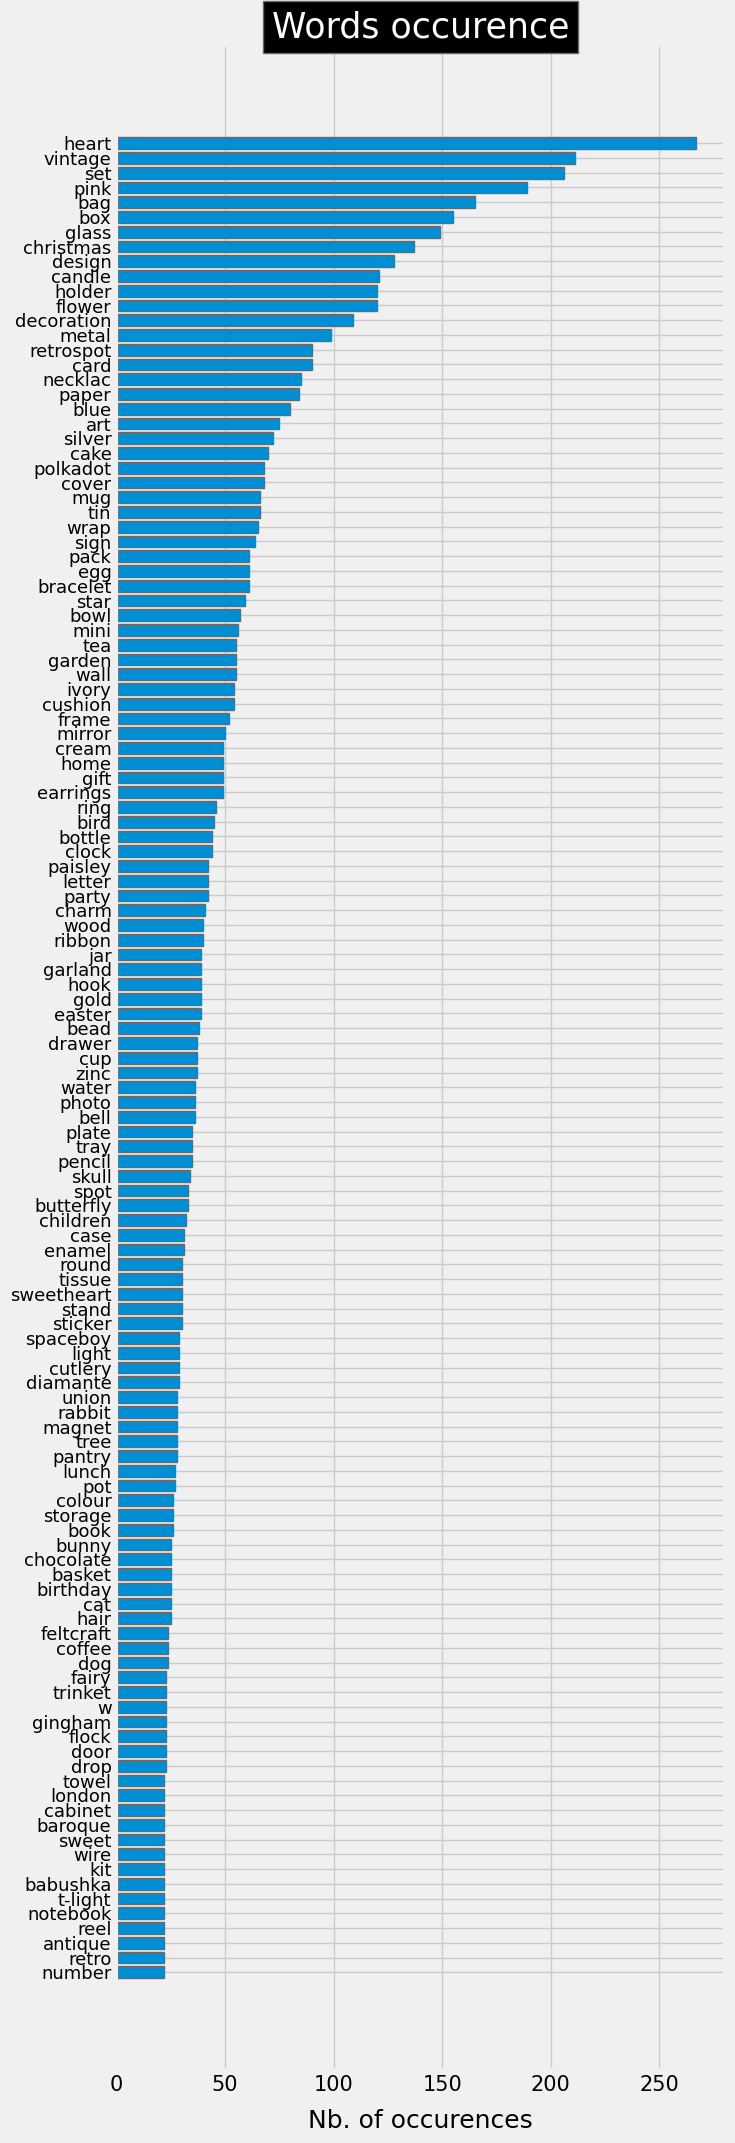

In [26]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

___
### 3.2 Defining product categories

I filtered the list by discarding irrelevant keywords, such as color names, and retained only those that appeared more than 13 times for further analysis.








In [27]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________
list_products.sort(key = lambda x:x[1], reverse = True)
print('preserved words:', len(list_products))

preserved words: 193


____
#### 3.2.1 Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the $X$ matrix as:

   
|   | mot 1  |  ...  | mot j  | ...  | mot N  |
|:-:|---|---|---|---|---|
| produit 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|produit i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| produit M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise.

In [28]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

<ipython-input-28-f281ed0528b9>:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-28-f281ed0528b9>:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-28-f281ed0528b9>:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-28-f281ed0528b9>:4: PerformanceWarning:

Da

The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers.
Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [29]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
    label_col.append(col)
    X[col] = 0  # Use assignment to create the column

# Now process the prices
for i, prod in enumerate(liste_produits):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j += 1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1


<ipython-input-29-0cfd73573e6e>:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-29-0cfd73573e6e>:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-29-0cfd73573e6e>:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-29-0cfd73573e6e>:9: PerformanceWarning:

Da

and to choose the appropriate ranges, I check the number of products in the different groups:

In [30]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.<{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    for col in X.columns:
     print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
heart       303                 
vintage     217                 
set         348                 
bag         188                 
box         164                 
glass       169                 
christmas   149                 
design      129                 
candle      158                 
holder      132                 
flower      145                 
decoration  108                 
metal       114                 
retrospot   96                  
card        105                 
necklac     94                  
paper       93                  
art         453                 
silver      94                  
cake        103                 
polkadot    72                  
cover       72                  
mug         70                  
tin         138                 
wrap        69                  
sign        196                 
pack        78                  
egg         64                  
bracelet    68          

____
#### 3.2.2 Creating clusters of products

I will group the products into different classes using the k-means method, despite its use of Euclidean distance being suboptimal for categorical variables, as the Hamming's metric is not available on the current platform; to determine the optimal number of clusters, I utilize the silhouette score.

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Convert DataFrame to NumPy array
matrix = X.to_numpy()

# Loop through the range of cluster numbers
for n_clusters in range(3, 10):
    # Initialize and fit KMeans model
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)

    # Predict the cluster for each data point
    clusters = kmeans.predict(matrix)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(matrix, clusters)

    # Print the silhouette score for the current number of clusters
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)


For n_clusters = 3 The average silhouette_score is : 0.10150779068464941
For n_clusters = 4 The average silhouette_score is : 0.12673477668888355
For n_clusters = 5 The average silhouette_score is : 0.12550495845018772
For n_clusters = 6 The average silhouette_score is : 0.14538055112167614
For n_clusters = 7 The average silhouette_score is : 0.14834827934676162
For n_clusters = 8 The average silhouette_score is : 0.15302956733115342
For n_clusters = 9 The average silhouette_score is : 0.11610093872960581


I chose to split the dataset into 5 clusters, iterating until achieving the best possible silhouette score of approximately 0.15, as scores stabilize around 0.1±0.05 for clusters with n_clusters > 3, with the first cluster yielding slightly lower scores.

In [32]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)


    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14579729104882663


___
#### 3.2.3  Characterizing the content of clusters

I check the number of elements in every class:

In [33]:
pd.Series(clusters).value_counts()

,count
4,1167
1,965
0,674
2,611
3,479



** a / _Silhouette intra-cluster score_ **

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

In [34]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

<ipython-input-34-a93f305e54eb>:18: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



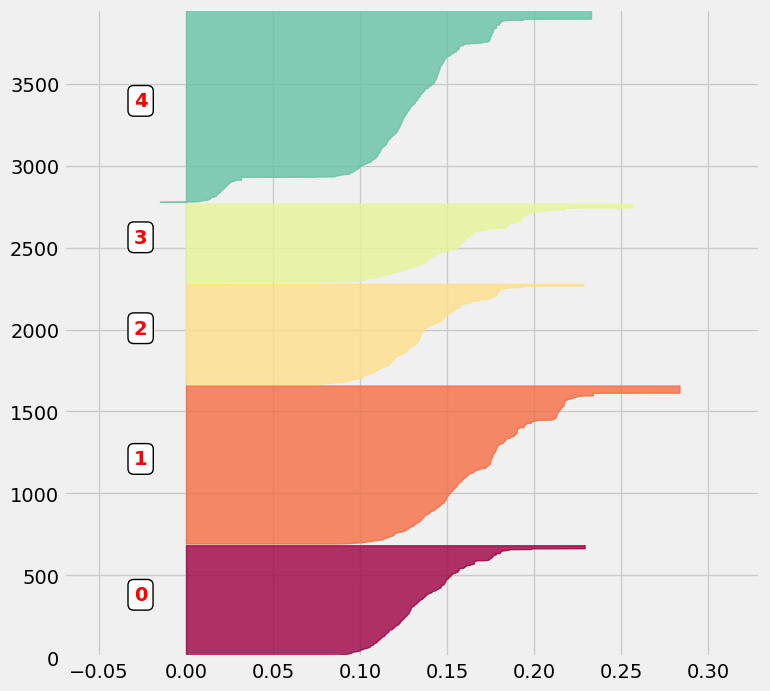

In [35]:
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)

# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)



Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [36]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

<ipython-input-37-7deeeca64d43>:18: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



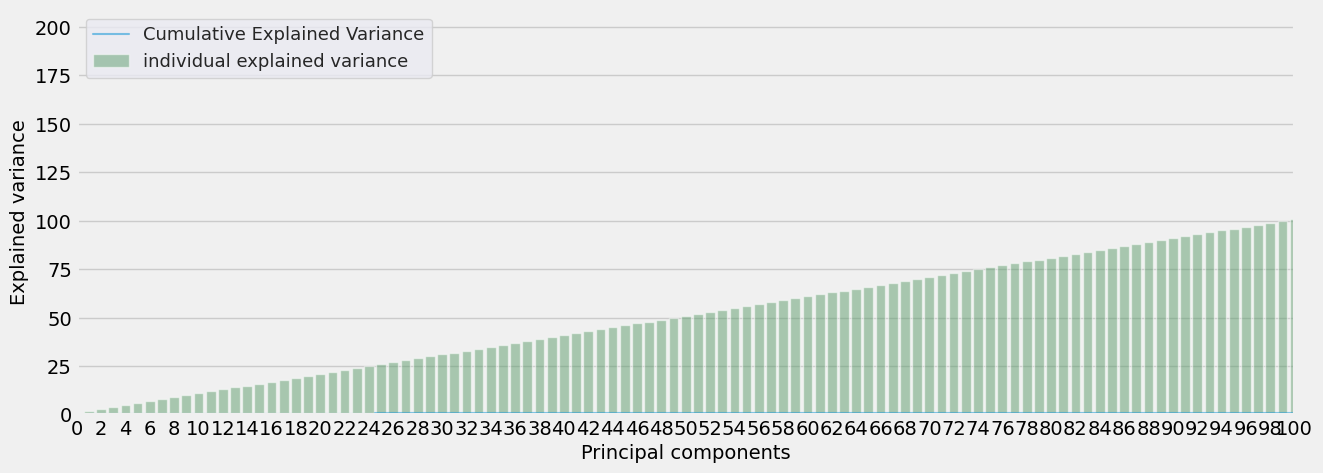

In [37]:
fig, ax = plt.subplots(figsize=(14, 5))
# Determine the number of principal components used in PCA
n_components = len(pca.explained_variance_ratio_)

sns.set(font_scale=1)

# Use the correct range based on the number of components


plt.step(range(1, n_components + 1), pca.explained_variance_ratio_.cumsum(),alpha=0.5, where='mid',
         label='Cumulative Explained Variance')


sns.barplot(np.arange(1,matrix.shape[1]+1), alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. In practice, I decide to keep only a limited number of components since this decomposition is only performed to visualize the data:

In [38]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

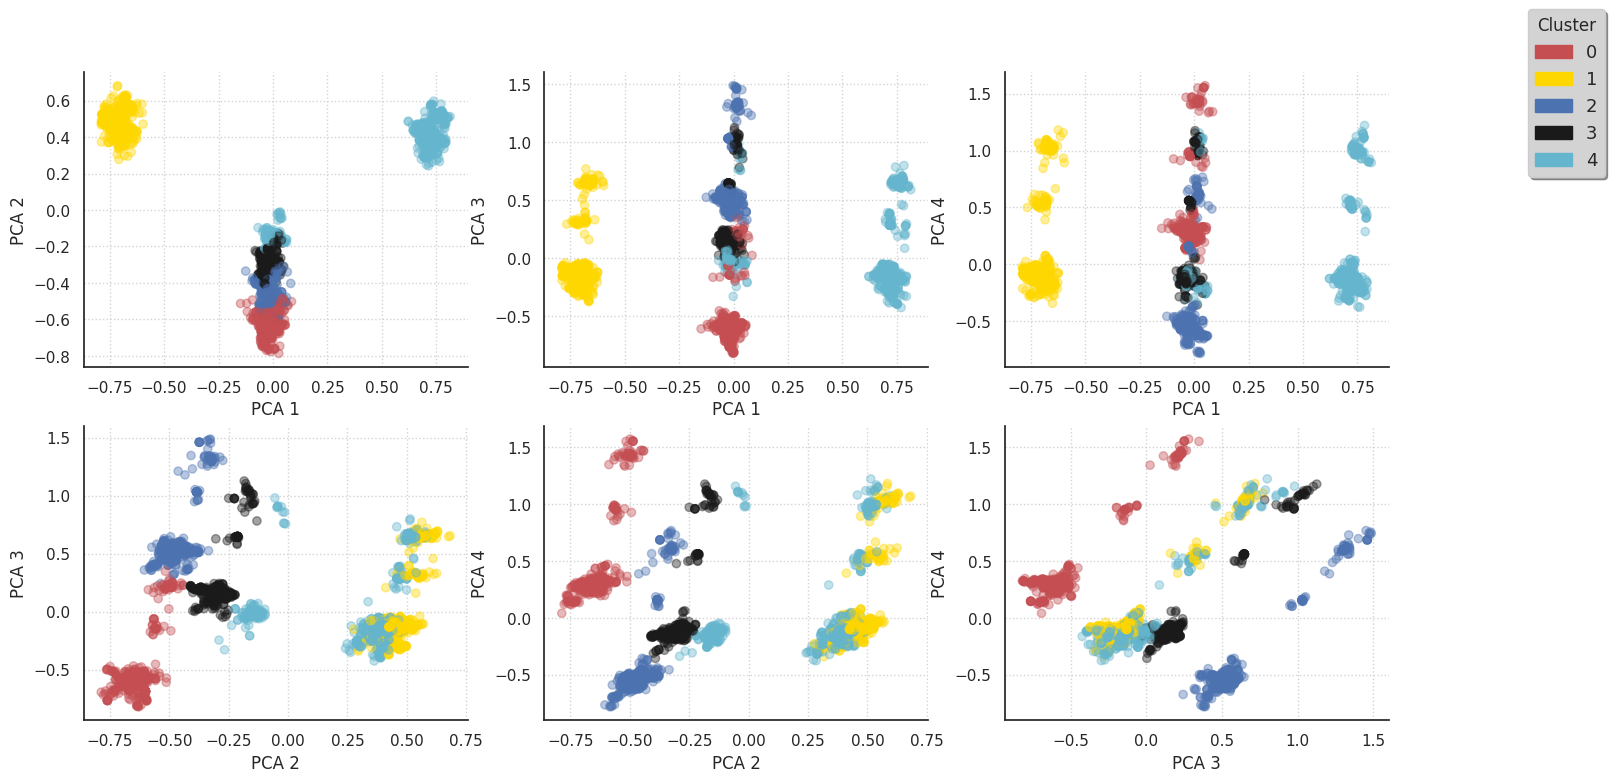

In [39]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 9: break
    if increment == 9: break

#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97),
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

___
## 4. Customer categories

### 4.1 Formatting data

In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable **categ_product** where I indicate the cluster of each product :

In [40]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

___
#### 4.1.1 Grouping products

In a second step, I decide to create the **categ_N** variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

In [41]:
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] )
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

<ipython-input-41-85800904d9c7>:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-41-85800904d9c7>:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.3,0.0,0.00,0.0,0.0
1,536365,WHITE METAL LANTERN,2,0.0,0.0,20.34,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,2,0.0,0.0,22.00,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2,0.0,0.0,20.34,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,2,0.0,0.0,20.34,0.0,0.0


Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [42]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

for i in range(5):
    col = 'categ_{}'.format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    # basket_price.loc[:, col] = temp
    basket_price.loc[:, col] = temp[col].values

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12346,541431,77183.60,0.00,0.00,0.00,0.00,77183.60,2011-01-18 10:01:00.000000000
2,12347,537626,711.79,83.40,23.40,293.35,124.44,187.20,2010-12-07 14:57:00.000000000
3,12347,542237,475.39,53.10,84.34,169.20,0.00,168.75,2011-01-26 14:29:59.999999744
4,12347,549222,636.25,71.10,81.00,115.00,0.00,369.15,2011-04-07 10:43:00.000000000
5,12347,556201,382.52,78.06,41.40,168.76,19.90,74.40,2011-06-09 13:01:00.000000000


#### 4.1.2 Separation of data over time

The dataframe `basket_price` contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [43]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [44]:
import pandas as pd
import datetime

# Convert the comparison date to a pandas datetime object
comparison_date = pd.to_datetime('2011-10-01')

# Now you can compare it directly to the InvoiceDate
set_entrainement = basket_price[basket_price['InvoiceDate'] < comparison_date]
set_test = basket_price[basket_price['InvoiceDate'] >= comparison_date]

____
#### 4.1.3 Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [45]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12346,1,77183.60,77183.60,77183.600000,77183.60,0.000000,0.000000,0.000000,0.000000,100.000000
1,12347,7,224.82,1294.32,615.714286,4310.00,20.805104,11.237123,29.540371,7.604176,30.813225
2,12348,4,227.44,892.80,449.310000,1797.24,0.000000,38.016069,0.000000,0.000000,61.983931
3,12349,1,1757.55,1757.55,1757.550000,1757.55,12.245455,4.513101,10.713778,20.389178,52.138488
4,12350,1,334.40,334.40,334.400000,334.40,27.900718,11.692584,0.000000,0.000000,60.406699


Finally, I define two additional variables that give the number of days elapsed since the first purchase (** FirstPurchase **) and the number of days since the last purchase (** LastPurchase **):

In [46]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

<ipython-input-46-7f234d718d3b>:6: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

<ipython-input-46-7f234d718d3b>:7: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12346,1,77183.60,77183.60,77183.600000,77183.60,0.000000,0.000000,0.000000,0.000000,100.000000,325,325
1,12347,7,224.82,1294.32,615.714286,4310.00,20.805104,11.237123,29.540371,7.604176,30.813225,2,367
2,12348,4,227.44,892.80,449.310000,1797.24,0.000000,38.016069,0.000000,0.000000,61.983931,75,358
3,12349,1,1757.55,1757.55,1757.550000,1757.55,12.245455,4.513101,10.713778,20.389178,52.138488,18,18
4,12350,1,334.40,334.40,334.400000,334.40,27.900718,11.692584,0.000000,0.000000,60.406699,310,310


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

In [47]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("Number of customers with a single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

Number of customers with a single purchase: 1493/4338  (34.42%)


___
### 4.2 Creation of customers categories

#### 4.2.1 Data encoding

The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [48]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].to_numpy()


In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I  create a matrix where these data are standardized:

In [50]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  4.27201475 262.3719207  653.64825081 417.64573488  21.52474433
  13.90376256  16.96274229  14.88333953  32.72541129]


I will perform PCA on the scaled_matrix to reduce its dimensionality before creating customer clusters, allowing for a clearer representation and evaluation of the separation quality between the groups.

In [51]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:

<ipython-input-52-51b5432621f3>:9: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



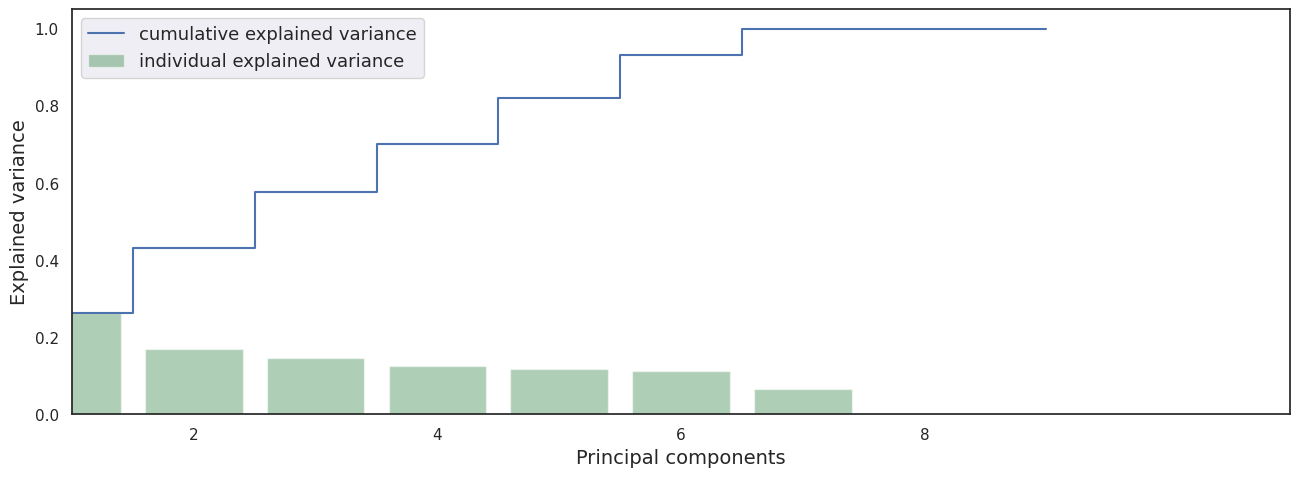

In [52]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid', label='cumulative explained variance')
# sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g', label='individual explained variance')
sns.barplot(x=np.arange(1, matrix.shape[1]+1), y=pca.explained_variance_ratio_, alpha=0.5, color='g', label='individual explained variance')
plt.xlim(0, 10)


ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

___
#### 4.2.2 Creation of customer categories

At this point, I define clusters of clients from the standardized matrix that was defined earlier and using the `k-means` algorithm from` scikit-learn`. I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 11 clusters:

In [53]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.207


At first, I look at the number of customers in each cluster:

In [54]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['number of clients']).T

""
number of clients


In [55]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)
scaled_matrix

array([[-4.25096503e-01,  6.33122942e+01,  2.47758907e+01, ...,
        -1.16473096e+00, -9.59380100e-01,  3.62960968e+00],
       [ 3.54416797e-01, -3.09082202e-02,  2.07411777e-01, ...,
         8.63631223e-01, -4.69214876e-01, -1.03166586e-01],
       [-3.53398530e-02, -2.87517516e-02,  7.74232502e-02, ...,
        -1.16473096e+00, -9.59380100e-01,  1.57856047e+00],
       ...,
       [-2.95177619e-01, -1.51884461e-01, -1.79170708e-01, ...,
         4.97398504e-01, -9.59380100e-01,  4.75203430e-01],
       [ 1.52368675e+00, -2.14347972e-01, -1.12208099e-01, ...,
        -7.79204049e-01, -8.36953585e-01,  1.22045087e-01],
       [-1.65258736e-01, -1.57777711e-01,  1.12555634e-01, ...,
        -9.89079381e-01, -8.40092889e-01,  1.08969278e+00]])

in order to create a representation of the various clusters:

In [56]:
mat['cluster']

,cluster
0,2
1,4
2,0
3,0
4,0
...,...
4333,7
4334,0
4335,4
4336,4


<ipython-input-77-b1daf450d623>:37: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.



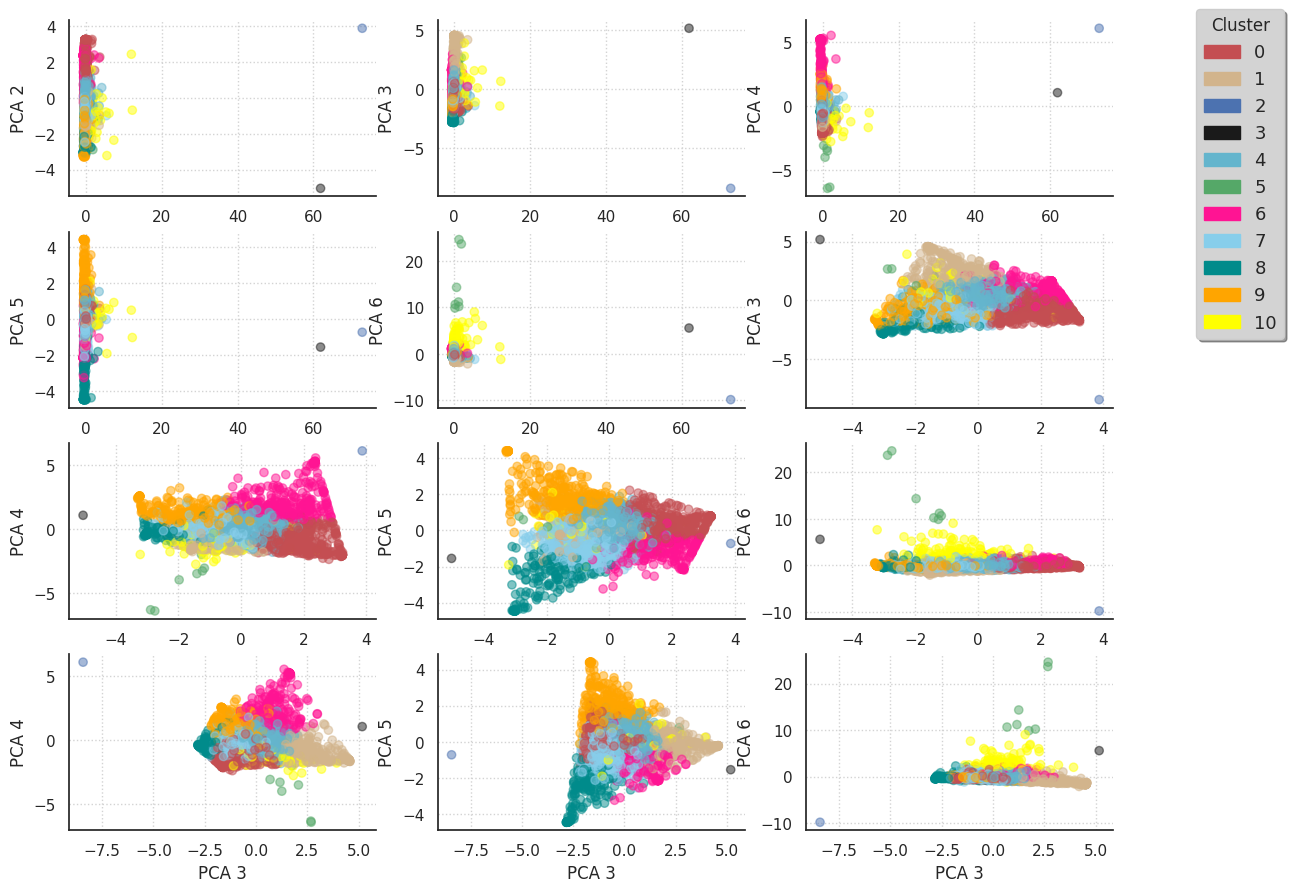

In [77]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 12: break
    if increment == 12: break

# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9),
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

The first principal component helps distinguish the smallest clusters, and generally, there is always a representation where two clusters appear distinct.

Intra-cluster Silhouette Score

To assess separation quality, I also evaluate silhouette scores within different clusters.

<ipython-input-34-a93f305e54eb>:18: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



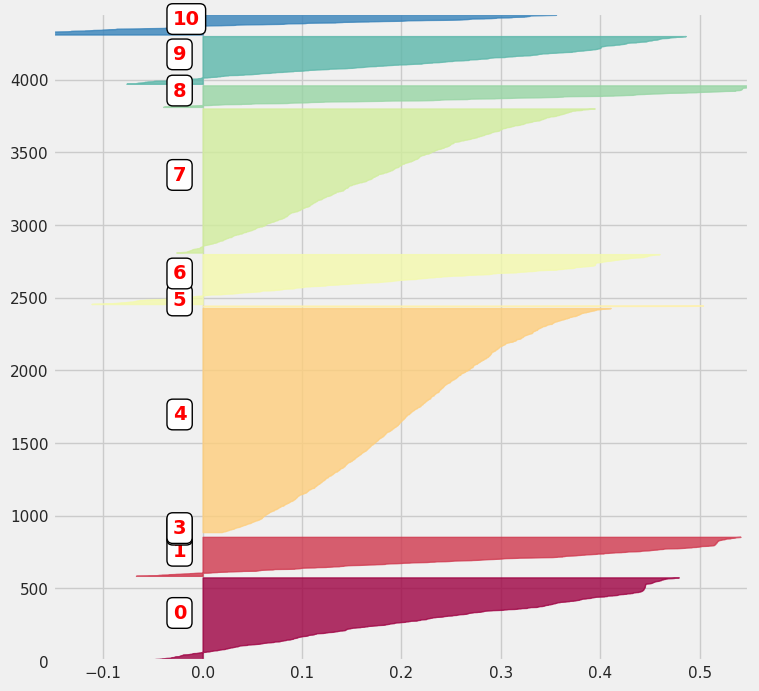

In [57]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

Having verified that the clusters are distinct, I now add a variable to the selected_customers dataframe to define the cluster each customer belongs to, in order to analyze their habits.

In [58]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

In [59]:
merged_df = pd.DataFrame()

for i in range(n_clusters):
    # Select only numeric columns for the current cluster
    cluster_data = selected_customers[selected_customers['cluster'] == i]

    # If there's data for the cluster
    if not cluster_data.empty:
        numeric_data = cluster_data.select_dtypes(include=['number'])

        # Handle missing values if needed (e.g., filling NaNs with 0)
        numeric_data = numeric_data.fillna(0)  # Modify as necessary

        # Calculate mean of numeric columns
        test = pd.DataFrame(numeric_data.mean()).T
        test['cluster'] = i  # Add cluster label to the result
        test.set_index('cluster', inplace=True)

        # Add size of the cluster
        test['size'] = cluster_data.shape[0]

        # Concatenate to merged_df
        merged_df = pd.concat([merged_df, test])
merged_df.drop('CustomerID', axis=1, inplace=True, errors='ignore')

# Add 'sum' column for sorting if needed
merged_df['sum'] = merged_df.sum(axis=1)

# Sort by 'sum'
merged_df = merged_df.sort_values('sum')



Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

In [60]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
#___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,1,2.985130,243.925279,461.926914,345.343511,2793.763771,66.964789,6.468020,6.826380,5.240332,14.500479,269
1,6,2.479651,223.032587,382.149419,288.324794,2442.765405,11.651188,51.171087,7.185254,5.910469,24.082003,344
2,9,2.714286,249.377994,443.539666,335.157295,2789.321612,13.856253,6.811478,52.831237,9.383987,17.117045,329
3,8,2.805369,279.093624,423.907718,343.144905,2626.893227,7.592061,3.389626,7.730497,70.203196,11.084619,149
4,0,2.666667,241.046243,417.984991,318.164497,2889.950636,10.262240,8.844002,7.417871,7.072971,66.402915,567
5,7,3.471774,247.581968,500.287522,360.277581,3761.188365,18.068370,8.376009,18.308205,27.616292,27.631123,992
6,4,3.936446,257.182315,590.535091,406.098061,4752.206135,24.667944,15.125037,16.807600,9.038275,34.361144,1542
7,10,26.532847,117.435036,3397.200876,949.788862,27751.593242,26.480915,10.832915,17.216345,15.395166,30.074659,137
8,5,128.714286,10.744286,2252.004286,390.279712,54682.898284,22.073250,13.610606,14.200175,17.367632,32.748337,7
9,2,1.000000,77183.600000,77183.600000,77183.600000,309486.400000,0.000000,0.000000,0.000000,0.000000,100.000000,1


In [61]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]

        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True,
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)

        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")

        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])

        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


This allows to have a global view of the content of each cluster:

<Figure size 1000x1200 with 0 Axes>

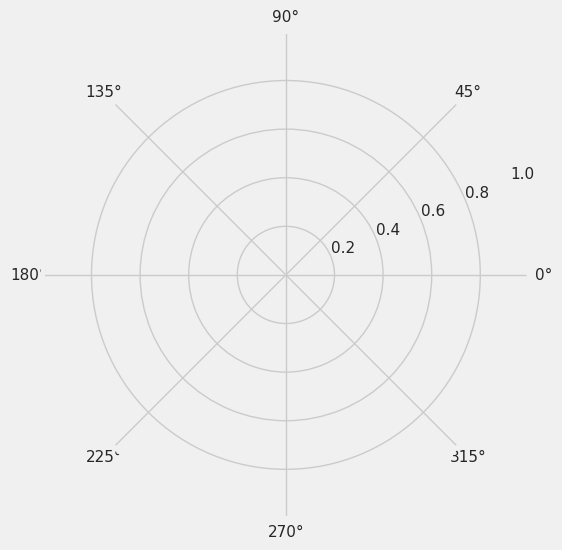

In [62]:
import numpy as np
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)
sizes = np.concatenate((sizes, [sizes[0]]))  # Closing the loop for radar chart
attributes = np.concatenate((attributes, [attributes[0]]))  # Closing the loop for labels
ranges = np.concatenate((ranges, [ranges[0]]))  # Closing the loop for ranges

# Radar chart plotting
num_vars = len(attributes)

# Set up the figure
fig, ax = plt.subplots(figsize=(6, 6), dpi=100, subplot_kw=dict(polar=True))

# Compute angle for each attribute
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()


for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y]


It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (** mean **), the total sum spent by the clients (** sum **) or the total number of visits made (** count **).

____

5. Classification of customers

In [63]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)

    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)

    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))


In [65]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [66]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)


5.1 Support Vector Machine Classifier (SVC)

In [67]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)
svc.grid_predict(X_test, Y_test)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Precision: 92.05 % 


5.1.1 Confusion matrix

In [68]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


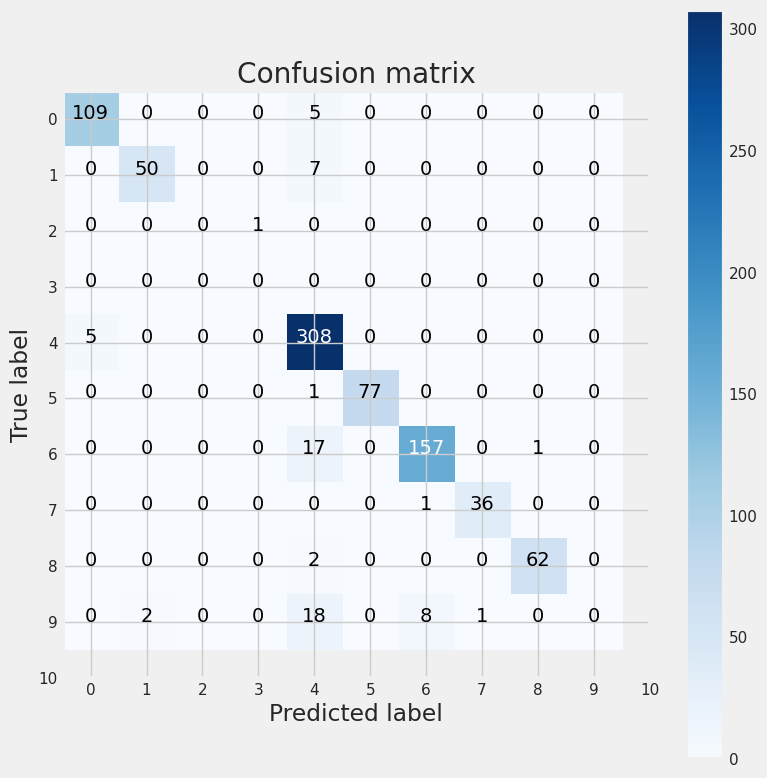

In [69]:

class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

___
#### 5.1.2 Learning curve

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model.

In [70]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### 5.2 Decision Tree

In [71]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Precision: 90.32 % 


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



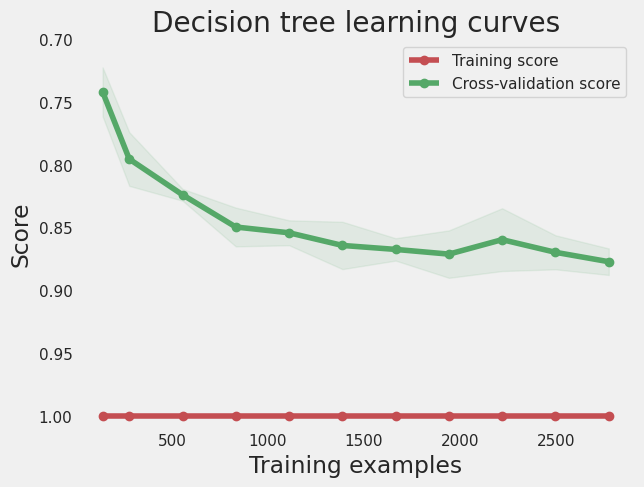

In [72]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

5.3 Random Forest

In [73]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Precision: 93.78 % 


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



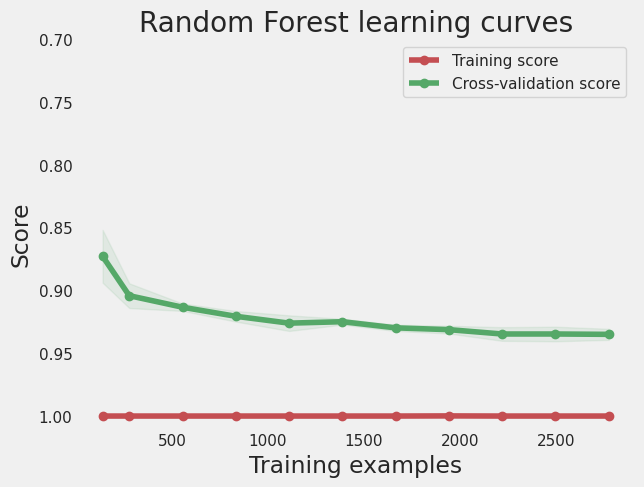

In [74]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [75]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)

6. COMPARING RESULTS

In [76]:

classifiers = [(svc, 'Support Vector Machine'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest')]
#_____________________________

for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 91.56 % 
______________________________ 
Decision Tree
Precision: 98.06 % 
______________________________ 
Random Forest
Precision: 98.76 % 


Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

In [ ]:
# !pip install session-info
# import session_info
# session_info.show()